# Trip Advisor Rating Analysis

This project uses the Trip Advisor Hotel Reviews dataset available from Kaggle at https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews . The data contains the text of the review as well as the rating from 1 to 5. The goal of this project is simple - predict the rating based on the review.

## EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import permutations
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

In [2]:
# Keep an unmodified copy of the data loaded if we want to go back to the original dataset
data_orig = pd.read_csv('tripadvisor_hotel_reviews.csv')
data = data_orig.copy()

# Array of the 5 rating values, useful for iterating over all ratings
ratings = [1, 2, 3, 4, 5]
n_ratings = 5

In [3]:
# Basic information
print(data.shape)
print(data.describe())
print(data.head())

(20491, 2)
             Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


This dataset has 20,491 reviews, and initially I wanted to use the entire dataset for the models, however that amounted to around 53,000 unique words and the models were simply taking too long to run on my computer. Therefore I'm going to limit this to just the first 2,000 reviews, but this is only for performance reasons - ideally I'd use the entire dataset. 

In [4]:
data = data.head(2000)

print(data.shape)
print(data.describe())
print(data.head())

(2000, 2)
            Rating
count  2000.000000
mean      3.832500
std       1.284628
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


Rating
1    173
2    188
3    243
4    593
5    803
dtype: int64


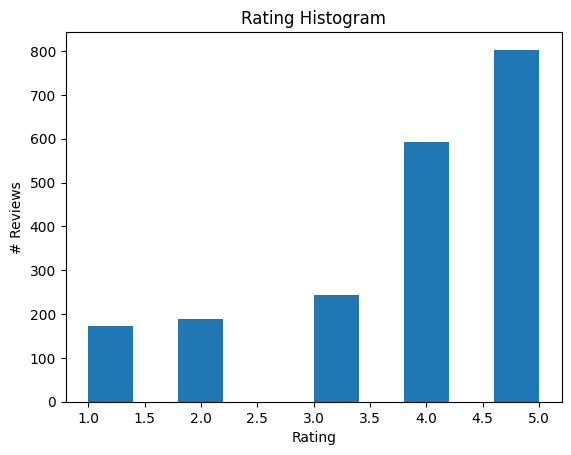

In [5]:
# Look at how many reviews each rating has
print(data.groupby('Rating').size())

plt.hist(data['Rating'])
plt.xlabel('Rating')
plt.ylabel('# Reviews')
plt.title('Rating Histogram')
plt.show()

Nearly half of the ratings are 5 star, and around 75% of all reviews are either 4 or 5 stars. I want to also look at the word clouds for each rating.

5 Rating Review Word Cloud


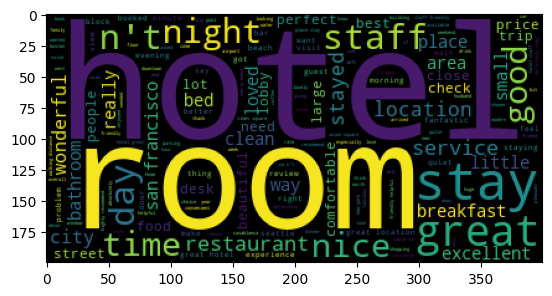

4 Rating Review Word Cloud


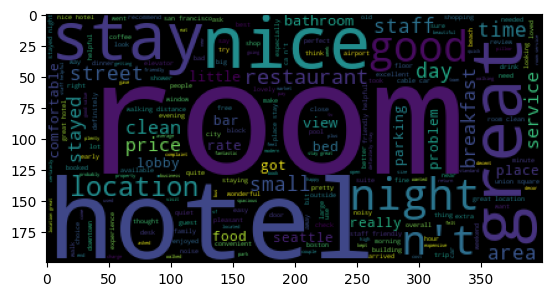

3 Rating Review Word Cloud


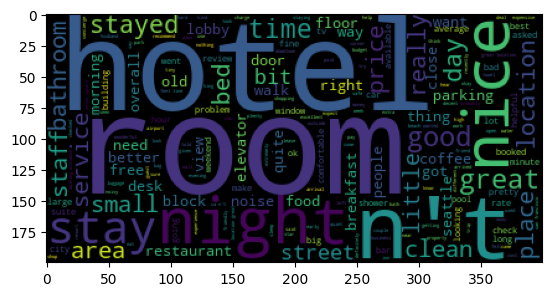

2 Rating Review Word Cloud


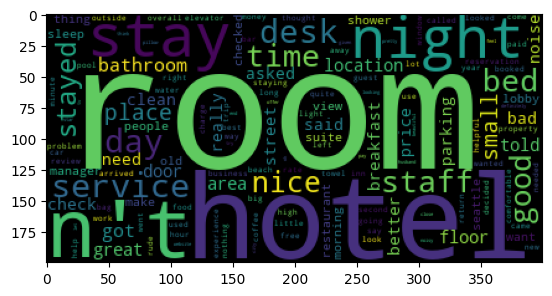

1 Rating Review Word Cloud


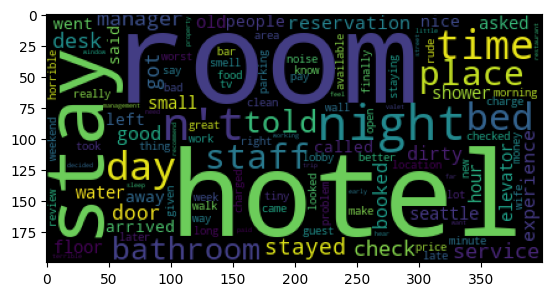

In [6]:
def show_word_cloud(rating):
    wordcloud = WordCloud().generate(' '.join(data[data['Rating'] == rating].Review))
    print(f'{rating} Rating Review Word Cloud')
    plt.imshow(wordcloud)
    plt.show()

for i in reversed(ratings):
    show_word_cloud(i)

It looks like reviews of all ratings have a lot of mentions of 'room', 'hotel', 'day, and 'night', which make sense for hotel reviews, but are not going to be useful for the model, so I'm going to remove them. The presensce of "n't" also seems a bit strange - after some digging, it looks like this dataset was already preprocessed and contractions such as "can't" were split into "can" and "n't", and the word "not" also appears to have been replaced with "n't". While I could recombine these to form the original contractions, it's probably better for the model to leave them separate since it better conveys their negative sentiment.

5 Rating Review Word Cloud


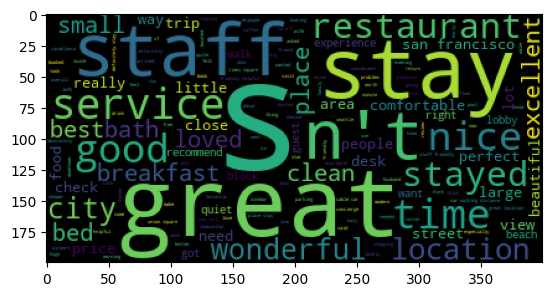

4 Rating Review Word Cloud


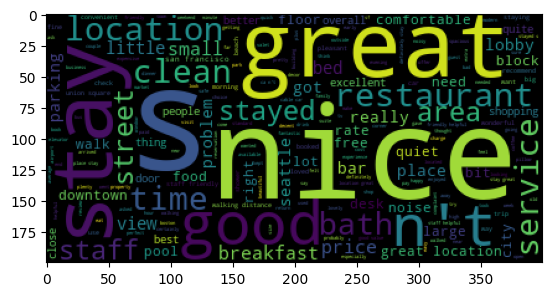

3 Rating Review Word Cloud


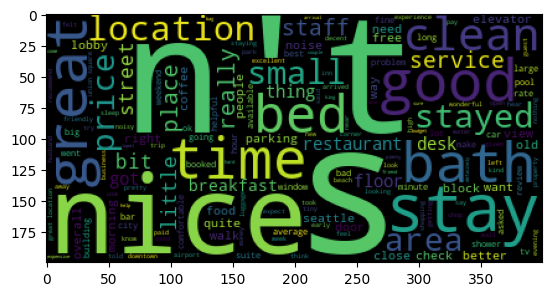

2 Rating Review Word Cloud


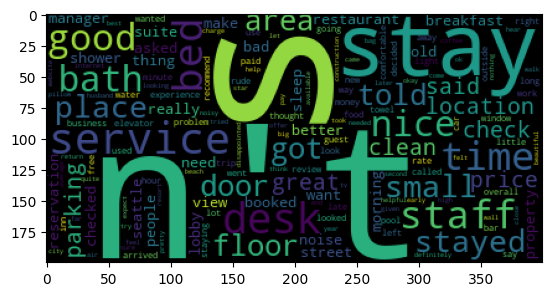

1 Rating Review Word Cloud


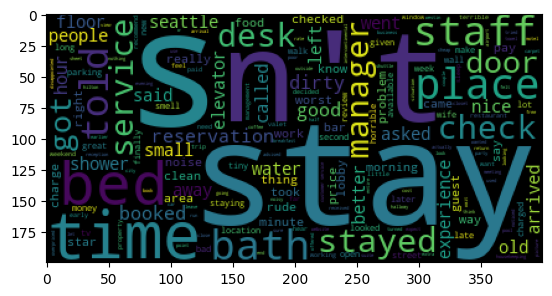

In [7]:
data['Review'] = data['Review'].str.replace('hotel', '')
data['Review'] = data['Review'].str.replace('room' ,'')
data['Review'] = data['Review'].str.replace('day', '')
data['Review'] = data['Review'].str.replace('night', '')

for i in reversed(ratings):
    show_word_cloud(i)

## Natural Lanaguage Processing (NLP)

I am using Term Frequency-Inverse Document Frequency (TF-IDF) for NLP. TF-IDF works by determing how relevant each word is to the overall text. This is accomplished by measuring how often a word appears for each record, where more occurrences make the word more relevant, and in how many records the word appears in, where occurrences in more records make the word less relevant. This means that words that appear in many records will have a lower relevancy score since they are less indicative as to the text's content. However, a word that does not appear very often, but when it does appear it is used multiple times in the same record, will have a high relevancy score.

I am using the TfidfVectorizer from sklearn for the NLP model, using the stop_words parameter in order to remove stop words from the dataset. Although, I believe this dataset has already been preprocessed to remove stopwords.

In [8]:
vectorizer = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = vectorizer.fit_transform(data['Review']).todense()
tfidf_array = np.asarray(tfidf_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix, columns=vectorizer.get_feature_names_out())

print(tfidf_matrix.shape)
print(tfidf_df.describe())
print(tfidf_df.head())


(2000, 12615)
                00          000         00am        00for          00p  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.005547     0.000278     0.000918     0.000051     0.000132   
std       0.029226     0.005519     0.014639     0.002259     0.004193   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.387108     0.152864     0.414580     0.101036     0.146836   

              00pm        00usd           01           02           03  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.000704     0.000100     0.000089     0.000038     0.000219  ...   
std       0.012263     0.004477     0.003980     0.001714     0.008319  ...   
min

There are 12,615 unique words in the dataset, and the TF-IDF matrix is very sparsly populated since the mean values are pretty close to zero.

## Agglomerative Clustering

First I'll use AgglomerativeClustering on this data with 5 clusters, since there are 5 ratings. I'll start with ward linkage and euclidean distance, as those are the defaults and have given the best results in the other assignments. I'll use the same function from the week 3 lab to map each cluster to a rating, and then compute the accuracy and display the confusion matrix.

In [9]:
def label_permute_compare(model_labels):
    best_label_order = None
    best_accuracy = 0
    
    for p in permutations(range(n_ratings)):
        p_pred = [ratings[p[i]] for i in model_labels]
        p_accuracy = accuracy_score(data.Rating, p_pred)
        
        if p_accuracy > best_accuracy:
            best_label_order = p
            best_accuracy = p_accuracy
            
    return (best_label_order, best_accuracy)

def show_confusion_matrix(pred):
    cm = confusion_matrix(data.Rating, pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ratings)
    
    cm_display.plot()
    plt.show()

accuracy 0.298


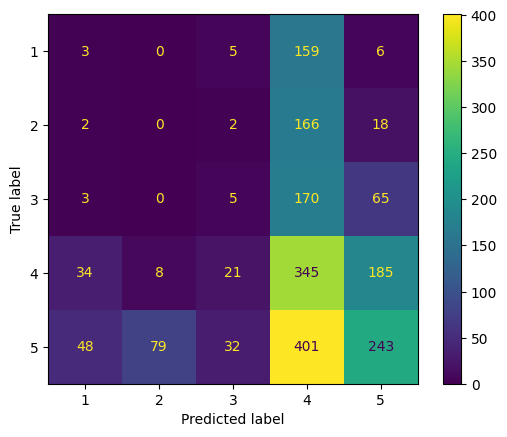

In [10]:
model_agglo = AgglomerativeClustering(n_clusters=5, linkage = 'ward',  metric='euclidean')
model_agglo.fit(tfidf_array)

#print(model_agglo.labels_)

labelorder, acc = label_permute_compare(model_agglo.labels_)
#print(labelorder)
print(f'accuracy {acc}')

pred_agglo = [ratings[labelorder[i]] for i in model_agglo.labels_]

show_confusion_matrix(pred_agglo)

This is a terrible fit as the accuracy is under 30%. The model generated 2 large clusters and 3 very small clusters, with a variety of true ratings in each cluster. The largest cluster best corresponds to a 4 rating, but actually contains more 5 rating reviews than 4. Maybe a different linkage or distance metric will give better results.

## Agglomerative Clustering - Hyperparameter Tuning

linkage ward, metric euclidean, accuracy 0.298
linkage complete, metric euclidean, accuracy 0.261
linkage complete, metric l1, accuracy 0.402
linkage complete, metric l2, accuracy 0.261
linkage complete, metric manhattan, accuracy 0.402
linkage complete, metric cosine, accuracy 0.3835
linkage average, metric euclidean, accuracy 0.4025
linkage average, metric l1, accuracy 0.402
linkage average, metric l2, accuracy 0.4025
linkage average, metric manhattan, accuracy 0.402
linkage average, metric cosine, accuracy 0.405
linkage single, metric euclidean, accuracy 0.403
linkage single, metric l1, accuracy 0.4015
linkage single, metric l2, accuracy 0.403
linkage single, metric manhattan, accuracy 0.4015
linkage single, metric cosine, accuracy 0.403
best was linkage average, metric cosine, accuracy 0.405


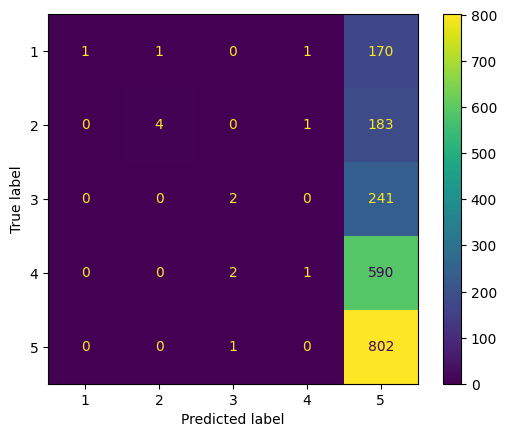

In [11]:
linkages = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

best_model = None
best_label_order = None
best_accuracy = 0

for linkage in linkages:
    for metric in metrics:
        
        # ward can only work with euclidean
        if linkage == 'ward' and metric != 'euclidean':
            continue
            
        model = AgglomerativeClustering(n_clusters=5, linkage = linkage, metric = metric)
        model.fit(tfidf_array)
        
        labelorder, acc = label_permute_compare(model.labels_)
        
        print(f'linkage {linkage}, metric {metric}, accuracy {acc}')
              
        if acc > best_accuracy:
            best_model = model
            best_label_order = labelorder
            best_accuracy = acc
            
print(f'best was linkage {best_model.linkage}, metric {best_model.metric}, accuracy {best_accuracy}')

pred = [ratings[best_label_order[i]] for i in best_model.labels_]

show_confusion_matrix(pred)

This is why accuracy alone is not a good way to measure a model's performance. While 40.5% accuracy is pretty bad on its own, it's especially bad when looking at the confusion matrix and realizing it generates one big cluster that has almost all of the ratings.

## Agglomerative Clustering With PCA

I want to try running PCA before moving onto another model. This might help the clusters become a bit more distinct if PCA is able to help identify the principle components that allow the clusters to distinguish the different ratings, especially for a high dimensionality dataset like this.

In [12]:
def run_pca_agglo(n_components):
    pca = PCA(n_components = n_components)
    
    pca.fit(tfidf_array)
    
    transformed_data = pca.transform(tfidf_array)
    
    model = AgglomerativeClustering(n_clusters=5, linkage = 'ward',  metric='euclidean')
    model.fit(transformed_data)

    return model

(2000, 12615)
n_components 25, accuracy 0.31
n_components 50, accuracy 0.31
n_components 100, accuracy 0.292
n_components 200, accuracy 0.296
n_components 500, accuracy 0.3195
n_components 1000, accuracy 0.318
n_components 2000, accuracy 0.298
best was with n_components = 500 with accuracy 0.3195


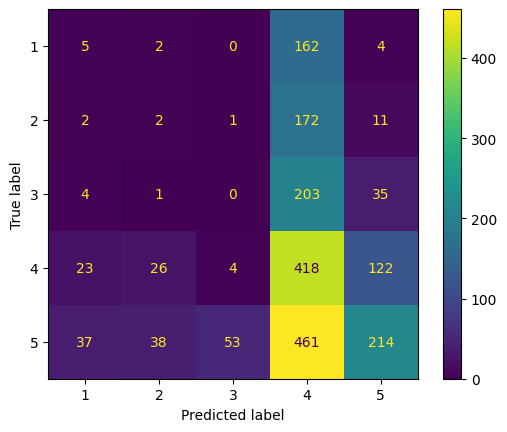

In [13]:
print(tfidf_array.shape)

n_components = [25, 50, 100, 200, 500, 1000, 2000]

best_n = 0
best_model = None
best_labelorder = None
best_acc = 0
for n in n_components:
    model = run_pca_agglo(n)
    
    labelorder, acc = label_permute_compare(model.labels_)
    print(f'n_components {n}, accuracy {acc}')
    
    if acc > best_acc:
        (best_n, best_model, best_labelorder, best_acc) = (n, model, labelorder, acc)

print(f'best was with n_components = {best_n} with accuracy {best_acc}')

pred = [ratings[best_labelorder[i]] for i in best_model.labels_]

show_confusion_matrix(pred)


31.7% accuracy using 1000 components is a slight improvement over 29.8% without PCA, but either way this is still not a good fit.

## KMeans

Next I'll see if KMeans is a better fit for this data. I'll use 5 clusters to correspond to the 5 ratings, but will leave other hyperparameters with their default values.

accuracy 0.3345


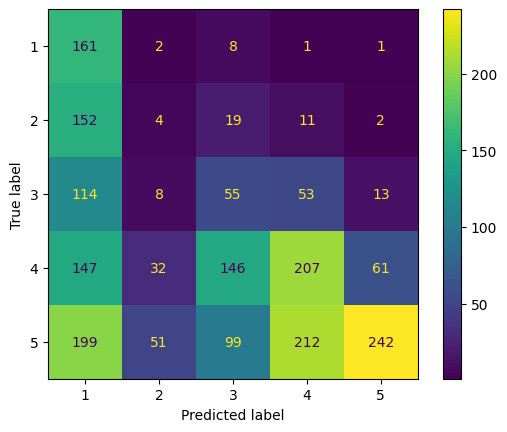

In [14]:
kmeans = KMeans(n_clusters = 5, n_init = 'auto')
kmeans.fit(tfidf_array)
labelorder, acc = label_permute_compare(kmeans.labels_)

print(f'accuracy {acc}')

pred_kmeans = [ratings[labelorder[i]] for i in kmeans.labels_]

show_confusion_matrix(pred_kmeans)


This is slightly better accuracy than Agglomerative Clustering, and the reviews are spread better amongst the clusters instead of concentrating in 2 clusters. This is still not a good fit for the data, though, since the accuracy is so low.

## Non-negative Matrix Factorization (NMF)

The last model I want to try is NMF. NMF models tend to perform better on sparse datasets compared to clustering, so I'm optimistic that this will be a better fit for the data. I'm going to look at the word cloud for the top 30 words for each component in order to determine which component maps to which rating.

In [15]:
def show_word_cloud_for_nmf_component(component):
    top_words = 30
    
    top_indexes = np.argpartition(component, -top_words)[-top_words:]
    top_values = np.asarray(component[top_indexes])

    top_word_frequencies = dict(zip([vectorizer.get_feature_names_out()[i] for i in top_indexes], top_values))
    
    wordcloud = WordCloud().generate_from_frequencies(top_word_frequencies)
    print(f'Component Top Word Cloud')
    plt.imshow(wordcloud)
    plt.show()

Component Top Word Cloud


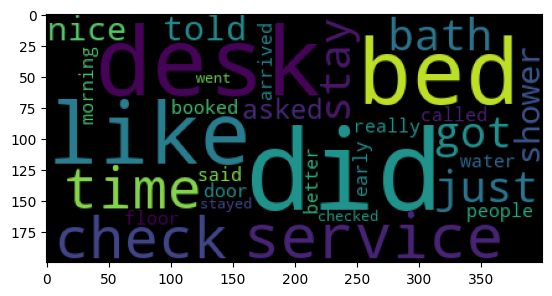

Component Top Word Cloud


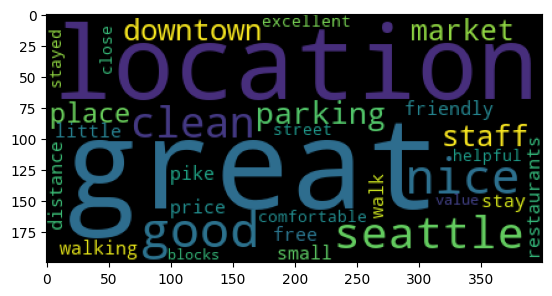

Component Top Word Cloud


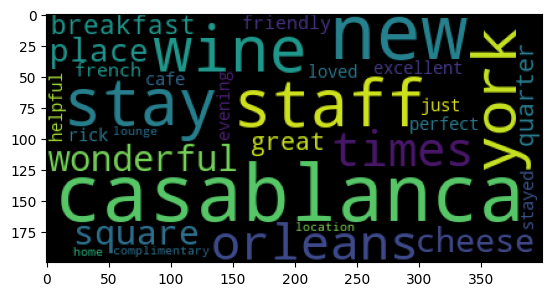

Component Top Word Cloud


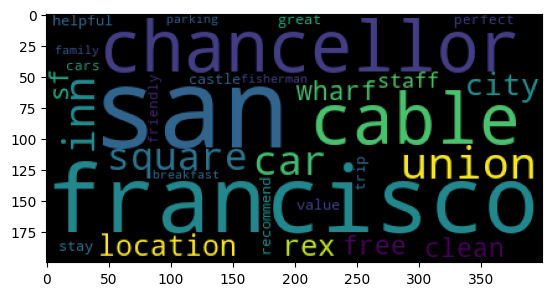

Component Top Word Cloud


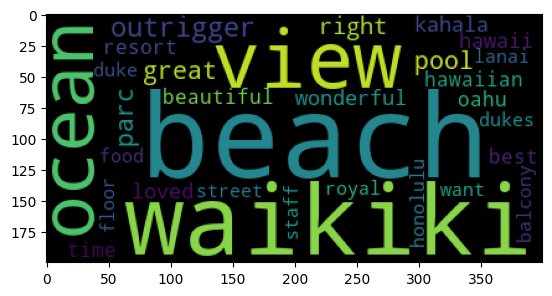

In [16]:
nmf = NMF(n_components = 5)
W = nmf.fit_transform(tfidf_array)
H = nmf.components_

for component in H:
    show_word_cloud_for_nmf_component(component)


Even without assigning each component to a rating it's clear that this is not a good fit. The last three models appear to be heavily influenced by reviews in specific locations (New York, New Orleans, and Casblanca in the first, San Francisco in the second, and Hawaii / Waikiki in the third), and while those places are quite nice, they are not good indicators as to a hotel rating.

## Conclusion

In conclusion, I do not feel any of these models were a good fit for the data. A lot of hotel reviews will use the same language (the name of the location, activities, food, etc.) regardless of whether the review is good or bad, which contributes to a lot of noise that can be difficult to filter out. More preprocessing would be beneficial here, to identify and remove the objective part of the review and instead focus on the part of the review that either praises or admonish the hotel. This would involve more thorough NLP than the TF-IDF I've used here, which is essentially just a fancy way of counting how often words occur.